<a href="https://www.kaggle.com/sdysch/nlp-disaster-tweets?scriptVersionId=88324181" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [28]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
print(df_train.columns)

df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
print(df_test.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [29]:
# preprocessing, lower case
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

In [30]:
# remove URLS
import re

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub(r'', text)

df_train['text'] = df_train['text'].apply(remove_urls)
df_test['text']  = df_test['text'].apply(remove_urls)

In [31]:
# removing stop words
from nltk.corpus import stopwords
def remove_stopwords(text):
    sw = stopwords.words('english')
    words = text.split(' ')
    filtered = [w for w in words if w not in sw]
    return ' '.join([str(v) for v in filtered])

df_train['text'] = df_train['text'].apply(remove_stopwords)
df_test['text']  = df_test['text'].apply(remove_stopwords)

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 40
n_words = 100000
tokenizer = Tokenizer(oov_token='<OOV>', num_words=n_words)
tokenizer.fit_on_texts(df_train['text'])
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(df_train['text'])
training_padded = pad_sequences(training_sequences, padding='post', maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(df_test['text'])
testing_padded    = pad_sequences(testing_sequences, padding='post', maxlen=max_length)
print(training_padded.shape)
print(testing_padded.shape)

(7613, 40)
(3263, 40)


# LSTM model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, GlobalAveragePooling1D, Dropout, Bidirectional
rnn_model = Sequential()
rnn_model.add(Embedding(n_words, 50))
#rnn_model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=False)))
rnn_model.add(LSTM(50, activation='relu', return_sequences=True))
rnn_model.add(LSTM(20, activation='relu', return_sequences=False))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(10, activation='relu'))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          5000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 50)          20200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 5,026,101
Trainable params: 5,026,101
Non-trainable params: 0
____________________________________________

In [34]:
# model is *really* prone to overfitting, only a few epochs needed
epochs = 4
batch_size = 32

y_train = df_train['target']

history = rnn_model.fit(training_padded,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          shuffle=True)

Epoch 1/4
191/191 [==============================] - 30s 147ms/step - loss: 7.9269 - accuracy: 0.5823 - val_loss: 0.6569 - val_accuracy: 0.5351
Epoch 2/4
191/191 [==============================] - 28s 146ms/step - loss: 0.5724 - accuracy: 0.7163 - val_loss: 0.5938 - val_accuracy: 0.7085
Epoch 3/4
191/191 [==============================] - 28s 148ms/step - loss: 0.5494 - accuracy: 0.8593 - val_loss: 0.5273 - val_accuracy: 0.7768
Epoch 4/4
191/191 [==============================] - 28s 144ms/step - loss: 0.2955 - accuracy: 0.9117 - val_loss: 0.5253 - val_accuracy: 0.7689


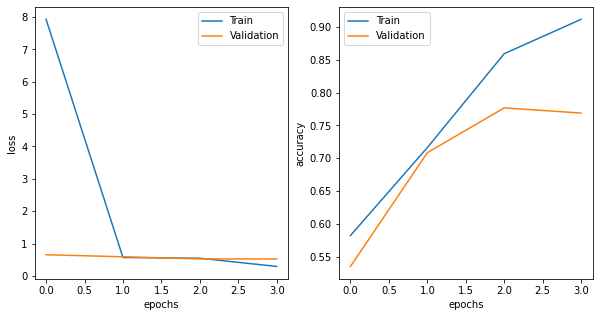

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(history.history['loss'], label='Train')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'], label='Train')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend(loc='best')


plt.show()

In [37]:
y_pred = rnn_model.predict(testing_padded)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
sub['target'] = y_pred.round(0).astype('int')
sub.to_csv('submission.csv', index=False)